---

# **Reinforcement Learning Black Jack** #

Kormishenkov Alexander, Ozerova Daria, Michael Kuznetsov


In [104]:
def train_dqn_per(
    n_episodes=5_000,
    max_steps_per_episode=100,
    print_every=500,
    # -- гиперпараметры DQN+PER --
    lr=1e-3,
    gamma=0.99,
    batch_size=64,
    capacity=10_000,
    alpha=0.6,
    beta_start=0.4,
    beta_frames=50_000,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=10_000,
    target_update_freq=1000
):

    agent = DQN_PER_Agent(
        state_dim=2,
        action_dim=2,  # hit или stick
        lr=lr,
        gamma=gamma,
        batch_size=batch_size,
        capacity=capacity,
        alpha=alpha,
        beta_start=beta_start,
        beta_frames=beta_frames,
        epsilon_start=epsilon_start,
        epsilon_end=epsilon_end,
        epsilon_decay=epsilon_decay,
        target_update_freq=target_update_freq
    )

    all_rewards = []
    for episode in range(1, n_episodes + 1):
        env = Jackblack()
        state = np.array([env.state["dealer_score"], env.state["player_score"]], dtype=np.float32)

        total_reward = 0.0
        done = False

        for t in range(max_steps_per_episode):
            if done:
                break

            action_idx = agent.select_action(state)
            env_action = env.actions[action_idx]
            next_state_dict, reward, done = env.step(env_action)
            next_state = np.array([next_state_dict["dealer_score"], next_state_dict["player_score"]], dtype=np.float32)
            total_reward += reward

            # сохраняем переход
            agent.remember(state, action_idx, reward, next_state, done)
            # update
            agent.update()

            state = next_state

        all_rewards.append(total_reward)

        if episode % print_every == 0:
            avg_reward = np.mean(all_rewards[-print_every:])
            print(f"[Episode {episode}] avg_reward: {avg_reward:.3f}, epsilon: {agent.epsilon:.3f}")

    return agent, all_rewards

In [112]:
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

alpha_list = [0.2, 0.6]
beta_start_list = [0.4, 0.6]
lr_list = [1e-3, 5e-4]
batch_size_list = [32, 64]

all_cumsum_df = [] 

for alpha in alpha_list:
    for beta_start in beta_start_list:
        for lr in lr_list:
            for batch_size in batch_size_list:
                print(f"\n>>> Testing alpha={alpha}, beta_start={beta_start}, lr={lr}, batch_size={batch_size}")

                # Запуск обучения
                agent, rewards = train_dqn_per(
                    n_episodes=2500,
                    max_steps_per_episode=100,
                    print_every=300,
                    lr=lr,
                    alpha=alpha,
                    beta_start=beta_start,
                    batch_size=batch_size
                )

                # Считаем кумулятивную сумму наград
                rewards_np = np.array(rewards)
                cumsum = np.cumsum(rewards_np)

                # Формируем DataFrame для текущего набора параметров
                df_temp = pd.DataFrame({
                    'Episode': np.arange(1, len(rewards_np) + 1),
                    'Cumulative Reward': cumsum
                })

                # Добавим столбец со строкой, описывающей параметры
                param_str = f"alpha={alpha},beta={beta_start},lr={lr},bs={batch_size}"
                df_temp['Params'] = param_str

                # Добавляем в общий список
                all_cumsum_df.append(df_temp)

# Один большой DataFrame
df_cumsum_all = pd.concat(all_cumsum_df, ignore_index=True)



>>> Testing alpha=0.2, beta_start=0.4, lr=0.001, batch_size=32
[Episode 300] avg_reward: -0.003, epsilon: 0.947
[Episode 600] avg_reward: -0.127, epsilon: 0.899
[Episode 900] avg_reward: -0.083, epsilon: 0.853
[Episode 1200] avg_reward: -0.150, epsilon: 0.801
[Episode 1500] avg_reward: -0.093, epsilon: 0.750
[Episode 1800] avg_reward: -0.057, epsilon: 0.699
[Episode 2100] avg_reward: 0.000, epsilon: 0.650
[Episode 2400] avg_reward: -0.040, epsilon: 0.598

>>> Testing alpha=0.2, beta_start=0.4, lr=0.001, batch_size=64
[Episode 300] avg_reward: -0.163, epsilon: 0.949
[Episode 600] avg_reward: -0.207, epsilon: 0.898
[Episode 900] avg_reward: -0.143, epsilon: 0.846
[Episode 1200] avg_reward: -0.123, epsilon: 0.786
[Episode 1500] avg_reward: -0.170, epsilon: 0.730
[Episode 1800] avg_reward: -0.137, epsilon: 0.677
[Episode 2100] avg_reward: 0.040, epsilon: 0.627
[Episode 2400] avg_reward: 0.003, epsilon: 0.577

>>> Testing alpha=0.2, beta_start=0.4, lr=0.0005, batch_size=32
[Episode 300] av

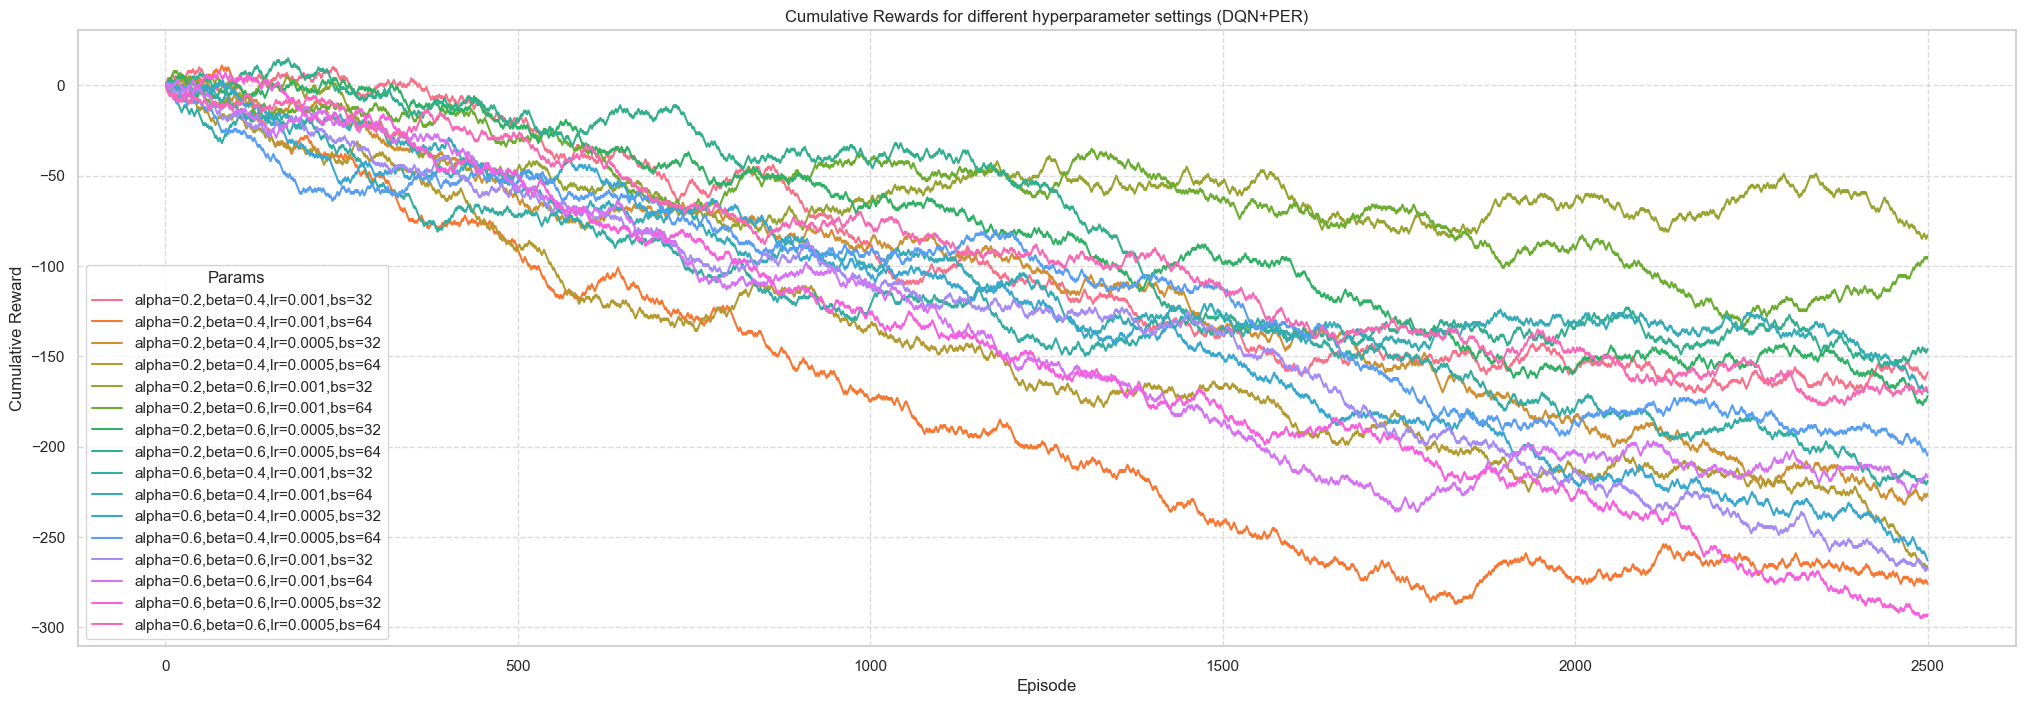

In [116]:
plt.figure(figsize=(25, 8))
sns.lineplot(
    data=df_cumsum_all,
    x='Episode',
    y='Cumulative Reward',
    hue='Params'
)
plt.title("Cumulative Rewards for different hyperparameter settings (DQN+PER)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
